In [1]:
!pip install lightning -qq

In [2]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
import torch 
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import lightning as L

from torchvision import transforms as T
import torch.nn.functional as F
import os 
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt 
import cv2
import numpy as np

def get_train_augs():
    return T.Compose([
        T.RandomRotation(0.2),
        T.RandomAutocontrast(),
        T.RandomResizedCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def get_valid_augs():
    return T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class IntelDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str):
        super().__init__()
        self.data_dir = data_dir 
        
        self.data_path = {
            "train" : os.path.join(self.data_dir, "seg_train", "seg_train"),
            "val"   : os.path.join(self.data_dir, "seg_test", "seg_test"),
            "test"  : os.path.join(self.data_dir, "seg_pred", "seg_pred")
        }
        
    def setup(self, stage: str) -> None:
        self.train_ds = ImageFolder(self.data_path["train"], transform=get_train_augs())
        self.val_ds   = ImageFolder(self.data_path["val"], transform=get_valid_augs())
    
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        train_loader     = DataLoader(self.train_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
        return train_loader

    def val_dataloader(self) -> EVAL_DATALOADERS:
        val_loader       = DataLoader(self.val_ds, batch_size=64,pin_memory=True, shuffle=False, num_workers=4)
        return val_loader 
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return super().test_dataloader()


In [31]:
from torch import nn
import torch
import torchvision
from torchvision.models.resnet import ResNet101_Weights


class ResnetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = torchvision.models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
    
        num_features = self.base_model.fc.in_features

        self.classifier=  nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ELU(),
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(256, num_classes)
            )
        
        self.base_model.fc = self.classifier
    
    def unfreeze_layers(self, unfreeze_layers: int = 50):
        
        for params in self.base_model.parameters():
            params.requires_grad = False

        # Get the total number of layers in the model
        total_layers = len(list(self.base_model.children()))

        # Unfreeze the last few layers
        for idx, child in enumerate(self.base_model.children()):
            if idx + 1 > total_layers - unfreeze_layers:
                for param in child.parameters():
                    param.requires_grad = True
        
        
    def forward(self, x):
        x = self.base_model(x)
        return x


In [32]:
import torch 
import torch.nn.functional as F
import lightning as L
import torch 
import torch.nn.functional as F
import lightning as L

class ModelTrainer(L.LightningModule):
    def __init__(self, classifier, learning_rate, debug=False, use_discriminative_lr: bool = True, lr_mult: int= 0.98):
        super().__init__()
        self.classifier = classifier
        self.learning_rate = learning_rate
        self.val_losses = []
        self.top_loss_images = []
        self.top_loss_true_labels = []
        self.top_loss_pred_labels = []
        self.debug = debug
        self.use_discriminative_lr= use_discriminative_lr
        self.lr_mult    = lr_mult

    def forward(self, img):
        output = self.classifier(img)
        return output

#     def parameters(self, recurse: bool = True):
#         if self.use_discriminative_lr:
#             parameters =  self._setup_discriminative_lr()
#         else:
#             parameters = super().parameters(recurse=recurse)

#         return parameters

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return opt

    def _setup_discriminative_lr(self):
        # save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.classifier.named_parameters()):
            layer_names.append(name)

        layer_names.reverse()
        lr = self.learning_rate
        lr_mult = self.lr_mult

        parameters = []

        # store params & learning rates
        for idx, name in enumerate(layer_names):
            # display info
            if self.debug:
                print(f'{idx}: lr = {lr:.6f}, {name}')

            # append layer parameters
            parameters += [{'params': [p for n, p in self.classifier.named_parameters() if n == name and p.requires_grad],
                            'lr': lr}]

            # update learning rate
            lr *= lr_mult

        return parameters

    def _make_prediction(self, batch, batch_idx):
        img_batch, label_batch = batch
        y_hat = self(img_batch)
        loss = F.cross_entropy(y_hat, label_batch, label_smoothing=0.1)
        probabilities = F.softmax(y_hat, dim=1)
        pred_labels = torch.argmax(probabilities, dim=1)

        accuracy = torch.sum(label_batch == pred_labels).item() / label_batch.size(0)
        return {'loss': loss, "accuracy": accuracy, 'predicted_labels': pred_labels, 'true_labels': label_batch}

    def training_step(self, train_batch, batch_idx):
        res = self._make_prediction(train_batch, batch_idx)

        self.log("loss", res["loss"], on_epoch=True, on_step=False, prog_bar=True)
        self.log("accuracy", res["accuracy"], on_epoch=True, on_step=False, prog_bar=True)
        return res

    def validation_step(self, valid_batch, batch_idx):

        res = self._make_prediction(valid_batch, batch_idx)
        self.log("val_loss", res["loss"], on_epoch=True, on_step=False, prog_bar=True)
        self.log("val_accuracy", res["accuracy"], on_epoch=True, on_step=False, prog_bar=True)

        # Check if the prediction is incorrect
        incorrect_indices = (res["predicted_labels"] != res["true_labels"]).nonzero(as_tuple=True)[0]

        # Store only the top 5 incorrect predictions
        for idx in incorrect_indices:
            if len(self.top_loss_images) < 5:
                top_loss_img = valid_batch[0][idx]
                top_loss_pred_label = res["predicted_labels"][idx]
                top_loss_true_label = res["true_labels"][idx]
                self.top_loss_true_labels.append(top_loss_true_label.item())
                self.top_loss_pred_labels.append(top_loss_pred_label.item())
                self.top_loss_images.append(top_loss_img)

        return res

In [33]:
config={
    "Data_Config" : {
        "base_path" : "/kaggle/input/intel-image-classification"
    },

    "Model_Config":{
        "learning_rate"  : 0.0001, 
        "num_classes"    : 6,
        "class_names"    : ["buildings", "forest", "glacier", "mountain", "sea", "street"],
        "patience"       : 3 
    }
}

In [34]:
import torch
from lightning.pytorch.tuner import Tuner
from torch.utils.data import DataLoader

import json 
import lightning as L 
from lightning.pytorch.callbacks import GradientAccumulationScheduler

# torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('medium')

if __name__ == "__main__":
    
    data_config = config["Data_Config"]
    model_config = config["Model_Config"]

    data_module = IntelDataModule(data_dir=data_config["base_path"])

    classifier = ResnetClassifier(num_classes=model_config["num_classes"])
    model_trainer = ModelTrainer(classifier, learning_rate=model_config["learning_rate"],
                                 debug=True, use_discriminative_lr=True)

    trainer = L.Trainer(
        callbacks=[
            L.pytorch.callbacks.EarlyStopping(monitor="val_loss", patience=model_config["patience"]),
            L.pytorch.callbacks.StochasticWeightAveraging(swa_lrs=1e-2),
        ],
        fast_dev_run=False
    )

    #     # Create a Tuner
    #     tuner = Tuner(trainer)

    #     tuner.lr_find(model_trainer, data_module)

    trainer.fit(model_trainer, data_module)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type             | Params
------------------------------------------------
0 | classifier | ResnetClassifier | 43.7 M
------------------------------------------------
43.7 M    Trainable params
0         Non-trainable params
43.7 M    Total params
174.728   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [36]:
model_trainer.learning_rate = 0.00001

In [35]:
classifier.unfreeze_layers()

In [37]:

trainer = L.Trainer(
    callbacks=[
        L.pytorch.callbacks.EarlyStopping(monitor="val_loss", patience=model_config["patience"]),
        L.pytorch.callbacks.StochasticWeightAveraging(swa_lrs=1e-2),
    ],
    fast_dev_run=False
)

trainer.fit(model_trainer, data_module)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type             | Params
------------------------------------------------
0 | classifier | ResnetClassifier | 43.7 M
------------------------------------------------
43.7 M    Trainable params
0         Non-trainable params
43.7 M    Total params
174.728   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Top Losses:
Image 1: Actual Label: buildings, Predicted Label: sea


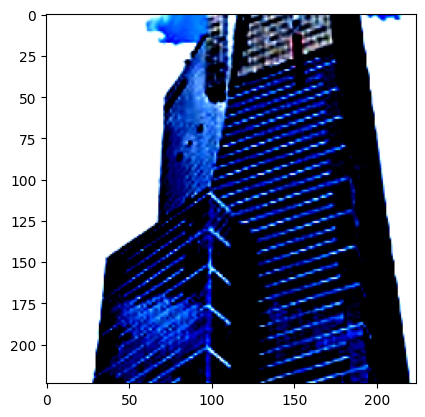

Image 2: Actual Label: buildings, Predicted Label: sea


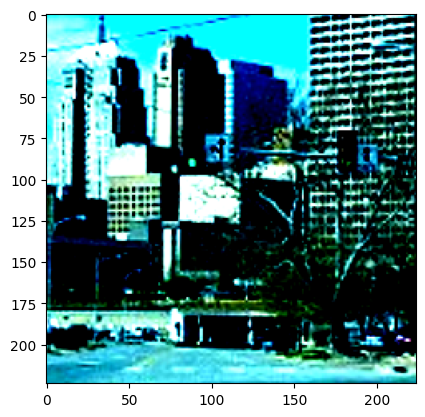

Image 3: Actual Label: buildings, Predicted Label: sea


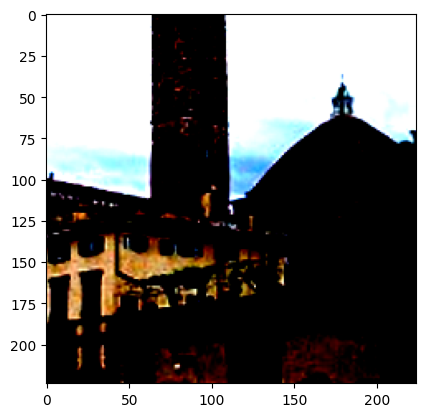

Image 4: Actual Label: buildings, Predicted Label: forest


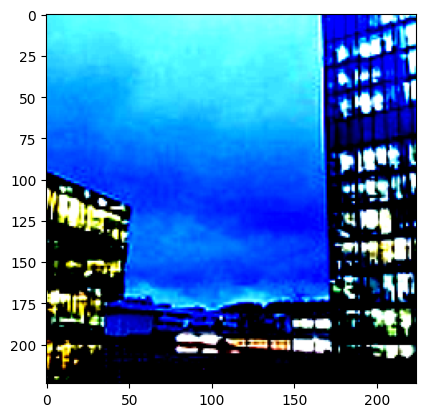

Image 5: Actual Label: buildings, Predicted Label: sea


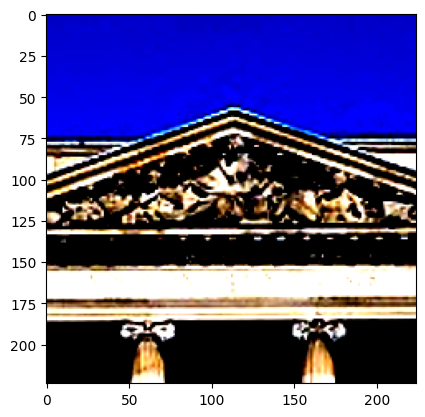

In [38]:
class_names = model_config["class_names"]
# Print top loss images with actual and predicted labels
print("Top Losses:")
for i, (img, true_label, pred_label) in enumerate(zip(model_trainer.top_loss_images, model_trainer.top_loss_true_labels, model_trainer.top_loss_pred_labels)):
    print(f"Image {i+1}: Actual Label: {class_names[true_label]}, Predicted Label: {class_names[ pred_label ]}")
    # Plot or display the image as per your preference
    plt.imshow(img.permute(1, 2, 0).cpu())
    plt.show()